# Prompt-to-Prompt: Prompt Editing 🚀
![teaser.png](https://i.imgur.com/ViFQxxF.png)

* **Paper**: [Prompt-to-Prompt Image Editing with Cross Attention Control](https://arxiv.org/abs/2208.01626)

* **Github**: https://github.com/miguelCalado/prompt-to-prompt-tensorflow

# Imports

In [1]:
import random

import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import gridspec
from matplotlib import pylab as P
from PIL import Image

from stable_diffusion import StableDiffusion

In [2]:
# Utility function
def ShowImage(im, ax=None, save_fig=None):
    if ax is None:
        P.figure()
    P.xticks([])
    P.yticks([])
    P.imshow(im)
    if save_fig:
        P.savefig(
            save_fig, dpi=200, bbox_inches="tight", pad_inches=0.0, transparent="True"
        )

# Setup GPU Strategy

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


2022-12-24 08:33:05.477730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 08:33:05.485127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 08:33:05.487410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
strategy = tf.distribute.get_strategy()

# Prompt-to-Prompt: Prompt Editing

In [5]:
generator = StableDiffusion(
    strategy=strategy,
    img_height=512,
    img_width=512,
    jit_compile=False,
)

2022-12-24 08:33:05.627802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 08:33:05.628917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 08:33:05.630784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 08:33:05.632578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Chiwawa Example

In [6]:
# Hyperparameters
prompt = "a photo of a chiwawa with sunglasses and a bandana"
num_steps = 50
unconditional_guidance_scale = 8
batch_size = 1
seed = 5681067

img_org = generator.text_to_image(
    prompt=prompt,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
    seed=seed,
    batch_size=batch_size,
)

2022-12-24 08:33:25.227041: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
  0   1: 100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


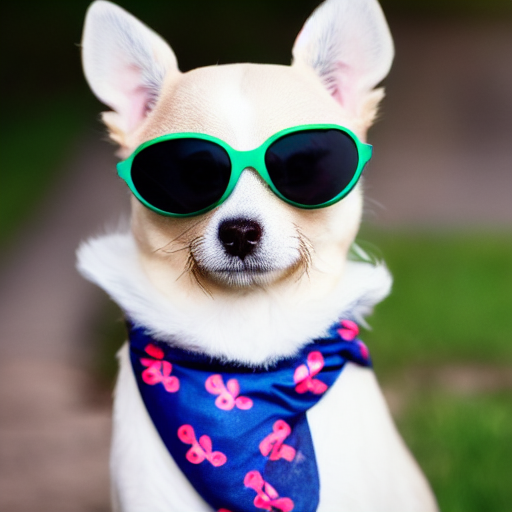

In [7]:
pil_img = Image.fromarray(img_org[0])
display(pil_img)

  0   1: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


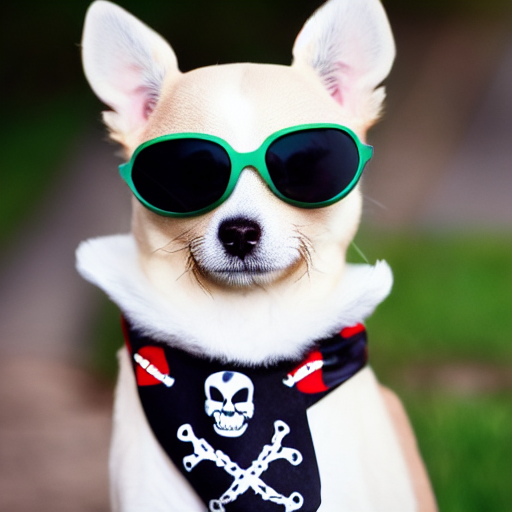

In [8]:
# Clean up the session to avoid clutter from old models and layers
tf.keras.backend.clear_session()

# Generate Prompt-to-Prompt
img_edit = generator.text_to_image_ptp(
    prompt="a photo of a chiwawa with sunglasses and a bandana",
    prompt_edit="a photo of a chiwawa with sunglasses and a pirate bandana",
    num_steps=50,
    unconditional_guidance_scale=8,
    cross_attn2_replace_steps_start=0.0,
    cross_attn2_replace_steps_end=1.0,
    cross_attn1_replace_steps_start=0.8,
    cross_attn1_replace_steps_end=1.0,
    seed=5681067,
    batch_size=1,
)

pil_img = Image.fromarray(img_edit[0])
display(pil_img)

In [9]:
ptp_dic = {
    "a photo of a chiwawa with sunglasses and a pirate bandana": 0.8,
    "a photo of a chiwawa with sunglasses and a clowd superman bandana": 0.88,
    "a photo of a chiwawa with aviator sunglasses and a Louis Vuitton bandana": 0.85,
    "a photo of a chiwawa with motorbike goggles and a pirate bandana": 0.90,
}

title_list = [
    "Original image",
    "Pirate bandana",
    "Superman bandana",
    "Aviator sunglasses\nLouis Vuitton bandana",
    "Motorbike goggles\nPirate bandana",
]

In [10]:
list_img = [img_org[0]]
for prompt_edit, attn1_start in ptp_dic.items():

    # Clean up the session to avoid clutter from old models and layers
    tf.keras.backend.clear_session()

    # Generate Prompt-to-Prompt
    img_edit = generator.text_to_image_ptp(
        prompt=prompt,
        prompt_edit=prompt_edit,
        num_steps=50,
        unconditional_guidance_scale=8,
        cross_attn2_replace_steps_start=0.0,
        cross_attn2_replace_steps_end=1.0,
        cross_attn1_replace_steps_start=attn1_start,
        cross_attn1_replace_steps_end=1.0,
        seed=5681067,
        batch_size=1,
    )
    list_img.append(img_edit[0])

  0   1: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]


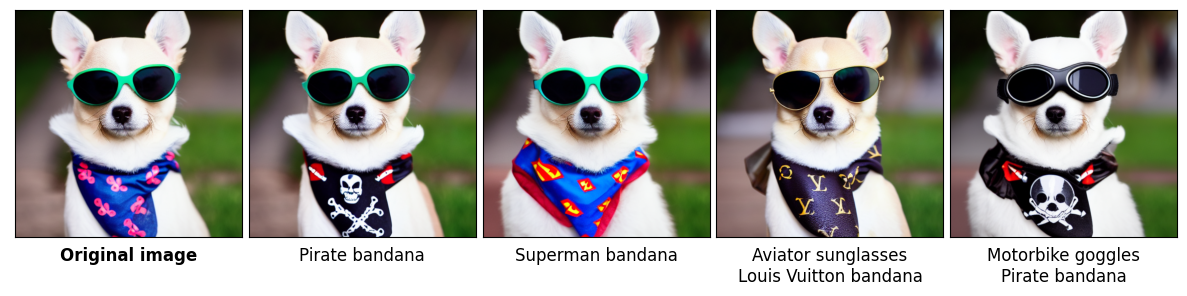

In [11]:
ROWS = 1  # 11
COLS = 5  # 11
FACTOR = 3

fig = plt.figure(figsize=(COLS * FACTOR, ROWS * FACTOR))
gs = gridspec.GridSpec(ROWS, COLS, wspace=0.01 * FACTOR, hspace=0.0 * FACTOR)
i = 0
j = 0
for gen_img, title in zip(list_img, title_list):
    ShowImage(gen_img, ax=P.subplot(gs[i, j]))
    if j:
        P.xlabel(title, fontsize=12)
    else:
        P.xlabel(title, fontsize=12, fontweight="bold")
    j += 1

## Teddy Bear Example

In [12]:
# Hyperparameters
prompt = "teddy bear with sunglasses relaxing in a pool"  # "a realistic photo of a woden basket full of apples"
num_steps = 50
unconditional_guidance_scale = 8
batch_size = 1
seed = 3345435

# Clean up the session to avoid clutter from old models and layers
tf.keras.backend.clear_session()

img_org = generator.text_to_image(
    prompt=prompt,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
    seed=seed,
    batch_size=batch_size,
)

  0   1: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


In [13]:
ptp_dic = {
    "teddy bear with heart-shaped red colored sunglasses relaxing in a pool": 1.0,
    "teddy bear with intelectual glasses relaxing in a pool": 0.6,
    "teddy bear with swimming goggles relaxing in a pool": 0.0,
    "teddy bear with aviator sunglasses relaxing in a pool": 0.50,
}

title_list = [
    "Original image",
    "heart-shaped\nred colored sunglasses",
    "intelectual glasses",
    "swimming goggles",
    "aviator sunglasses",
]

In [14]:
list_img = [img_org[0]]
for prompt_edit, attn1_start in ptp_dic.items():

    # Clean up the session to avoid clutter from old models and layers
    tf.keras.backend.clear_session()

    # Generate Prompt-to-Prompt
    img_edit = generator.text_to_image_ptp(
        prompt=prompt,
        prompt_edit=prompt_edit,
        num_steps=num_steps,
        unconditional_guidance_scale=unconditional_guidance_scale,
        cross_attn2_replace_steps_start=0.0,
        cross_attn2_replace_steps_end=1.0,
        cross_attn1_replace_steps_start=attn1_start,
        cross_attn1_replace_steps_end=1.0,
        seed=seed,
        batch_size=batch_size,
    )
    list_img.append(img_edit[0])

  0   1: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


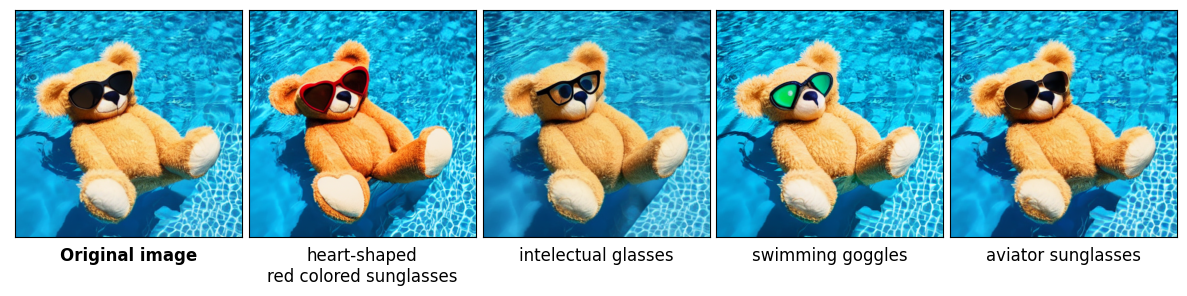

In [15]:
ROWS = 1  # 11
COLS = 5  # 11
FACTOR = 3

fig = plt.figure(figsize=(COLS * FACTOR, ROWS * FACTOR))
gs = gridspec.GridSpec(ROWS, COLS, wspace=0.01 * FACTOR, hspace=0.0 * FACTOR)
i = 0
j = 0
for gen_img, title in zip(list_img, title_list):
    ShowImage(gen_img, ax=P.subplot(gs[i, j]))
    if j:
        P.xlabel(title, fontsize=12)
    else:
        P.xlabel(title, fontsize=12, fontweight="bold")
    j += 1